In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random

In [2]:
V_A_old = 2
V_A_new = 2.3
theta_A = 2

dt = 1e-4
dB = np.sqrt(dt)

N_sim = int(10e3)

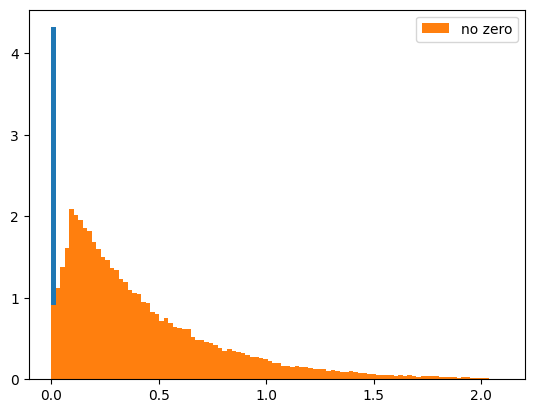

In [9]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

LED_times = (df['intended_fix'] - df['LED_onset_time']).values
plt.hist(LED_times, bins=100, density=True);

# remove zero from LED_times
LED_times = LED_times[LED_times != 0]
plt.hist(LED_times, bins=100, density=True, label='no zero');

LED_times = np.unique(LED_times)


stim_times = df['intended_fix'].values
stim_times = np.unique(stim_times)

plt.legend();

filtered_df = df[df['intended_fix'] - df['LED_onset_time'] != 0]

# Create the list of tuples
tuple_column = list(zip(filtered_df['intended_fix'], filtered_df['intended_fix'] - filtered_df['LED_onset_time']))



In [10]:
np.array([a < b for a, b in tuple_column]).sum()

0

In [11]:
def simulate_single_bound_V_A_change(V_A_old, V_A_new, a, dt):
    t = 0
    DV = 0

    # t_LED = np.random.choice(LED_times)
    # # t_LED = 0.5
    # t_stim = np.random.choice(stim_times)
    # # t_stim = 0.5
    stim_led_pair = tuple_column[np.random.choice(len(tuple_column))]
    t_stim = stim_led_pair[0]
    t_LED = stim_led_pair[1]

    if t_stim < t_LED:
        print('This is not possible')

    while True:
        if t >= t_LED:
            v = V_A_new
        else:
            v = V_A_old
        
        t += dt
        DV += v*dt + np.random.normal(0, dB)
        
        if DV >= a:
            return t, t_LED, t_stim
        

In [12]:
sim_results = Parallel(n_jobs=-1)(delayed(simulate_single_bound_V_A_change)(V_A_old, V_A_new, theta_A, dt) for _ in tqdm(range(N_sim)))

100%|██████████| 10000/10000 [00:43<00:00, 229.70it/s]


In [7]:
# from V_A_step_jump_fit_utils import PDF_hit_V_A_change, CDF_hit_V_A_change
# from tqdm import tqdm

# bw = 0.05
# bins = np.arange(0, 5, bw)
# t_pts = bins[:-1] + bw/2
# non_censored_theory = np.zeros((N_sim, len(t_pts)))
# censored_theory = np.zeros((N_sim,))

# for i, (rt, t_LED, t_stim) in tqdm(enumerate(sim_results), total=len(sim_results)):
#     if rt < t_stim:
#         non_censored_theory[i,:] = [PDF_hit_V_A_change(t, V_A_old, V_A_new, theta_A, t_LED) for t in t_pts]
#         censored_theory[i] = np.nan
#     else:
#         non_censored_theory[i,:] = np.nan
#         censored_theory[i] = 1 - CDF_hit_V_A_change(t_stim, V_A_old, V_A_new, theta_A, t_LED)

In [77]:
from V_A_step_jump_fit_utils import PDF_hit_V_A_change, CDF_hit_V_A_change
from tqdm import tqdm
from joblib import Parallel, delayed
import numpy as np

bw = 0.01
bins = np.arange(0, 3, bw)
t_pts = bins[:-1] + bw / 2
N_sim = len(sim_results)  # Define N_sim based on your sim_results
area_aborts_non_censored = np.zeros((N_sim,))

non_censored_theory = np.zeros((N_sim, len(t_pts)))
censored_theory = np.zeros((N_sim,))

all_non_censor_theory = np.zeros((N_sim, len(t_pts)))
all_censor_theory = np.zeros((N_sim,))

def process_sim_result(i, rt, t_LED, t_stim, V_A_old, V_A_new, theta_A):
    non_censored = np.array([PDF_hit_V_A_change(t, V_A_old, V_A_new, theta_A, t_LED) for t in t_pts])
    t_stim_mask = (t_pts < t_stim).astype(int)
    non_censored = non_censored * t_stim_mask


    censored = 1 - CDF_hit_V_A_change(t_stim, V_A_old, V_A_new, theta_A, t_LED)

    return i, non_censored, censored

# Parallel processing
results = Parallel(n_jobs=-1)(
    delayed(process_sim_result)(i, rt, t_LED, t_stim, V_A_old, V_A_new, theta_A)
    for i, (rt, t_LED, t_stim) in tqdm(enumerate(sim_results), total=len(sim_results))
)

# Consolidate results
for i, non_censored, censored in results:
    non_censored_theory[i, :] = non_censored
    censored_theory[i] = censored













































































































































































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 10000/10000 [01:23<00:00, 120.37it/s]


In [78]:
non_censored_theory.shape, censored_theory.shape

((10000, 299), (10000,))

In [79]:
all_areas = np.zeros((N_sim,))
for i in range(N_sim):
    all_areas[i]  = np.trapz(non_censored_theory[i,:], t_pts)

In [80]:
np.mean(all_areas)

0.24514084423828808

# rough

In [81]:
all_areas = np.zeros((N_sim,))
for i in range(N_sim):
    all_areas[i] = np.trapz(non_censored_theory[i, :], t_pts)

In [82]:
np.nanmean(all_areas)

0.24514084423828808

In [83]:
# num of non mean in all_areas
np.sum(~np.isnan(all_areas))/N_sim

1.0

(array([    0.,     0.,     0.,     0.,     0., 10000.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

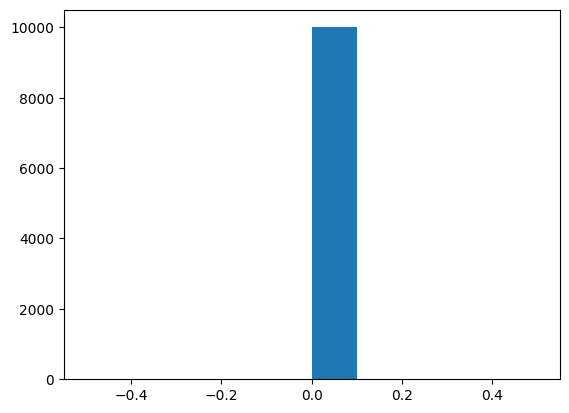

In [84]:
# plt.hist(all_areas)
plt.hist(area_aborts_non_censored)

# rough

<BarContainer object of 299 artists>

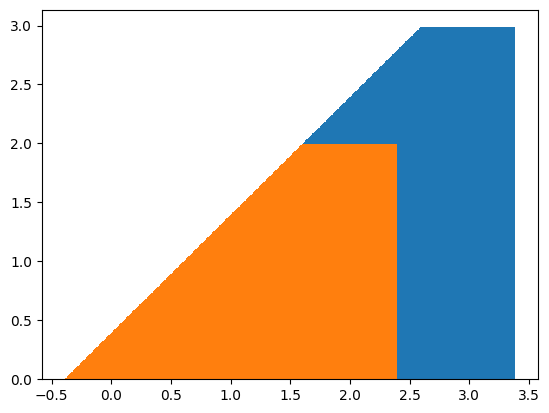

In [85]:
plt.bar(t_pts, t_pts)
mask = (t_pts < 2).astype(int)

t_pts_mask = t_pts*mask

plt.bar(t_pts, t_pts_mask)

In [86]:
test = non_censored_theory

areas = np.zeros((N_sim,))
for i in range(N_sim):
    areas[i] = np.trapz(test[i,:], t_pts)


In [87]:
np.nanmean(areas), areas.shape

(0.24514084423828808, (10000,))

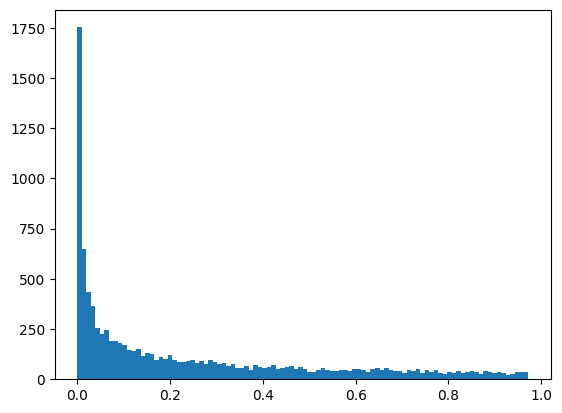

In [88]:
plt.hist(areas, bins=100);

In [89]:
non_censored_nan_removed = non_censored_theory[~np.isnan(non_censored_theory).all(axis=1)]
print(non_censored_nan_removed.shape)

(10000, 299)


In [90]:
censored_nan_removed = censored_theory[~np.isnan(censored_theory)]
print(censored_nan_removed.shape)

(10000,)


In [91]:
non_censored_nan_removed_mean = np.mean(non_censored_nan_removed, axis=0)
non_censored_nan_removed_mean.shape

(299,)

In [92]:
censored_nan_removed_mean = np.mean(censored_nan_removed)
censored_nan_removed_mean

0.7548525333600482

In [101]:
N_aborts = [1 for rt, _, t_stim in sim_results if rt < t_stim]
N_aborts = np.sum(N_aborts)

In [102]:
abort_rt_data = [rt for rt, _,t_stim in sim_results if rt < t_stim]

abort_rt_data_hist, _ = np.histogram(abort_rt_data, bins=bins, density=True)
abort_rt_data_hist *= N_aborts/N_sim

In [103]:
# cdf_till_t_stim = np.zeros((N_sim,))
# for i, (_, t_LED, t_stim) in enumerate(sim_results):
#     cdf_till_t_stim[i] = CDF_hit_V_A_change(t_stim, V_A_old, V_A_new, theta_A, t_LED)

cdf_till_t_stim = np.zeros((N_sim,))
def compute_cdf(i, t_stim, t_LED, V_A_old, V_A_new, theta_A):
    return i, CDF_hit_V_A_change(t_stim, V_A_old, V_A_new, theta_A, t_LED)

# Parallel processing
results = Parallel(n_jobs=32)(
    delayed(compute_cdf)(i, t_stim, t_LED, V_A_old, V_A_new, theta_A)
    for i, (_, t_LED, t_stim) in tqdm(enumerate(sim_results), total=len(sim_results))
)

# Consolidate results into the original array
for i, cdf_value in results:
    cdf_till_t_stim[i] = cdf_value



























































100%|██████████| 10000/10000 [00:03<00:00, 3085.55it/s]


In [104]:
cdf_till_t_stim_mean = np.mean(cdf_till_t_stim)
cdf_till_t_stim_mean

0.2451474666399518

In [105]:
non_censored_nan_removed_mean_norm = non_censored_nan_removed_mean

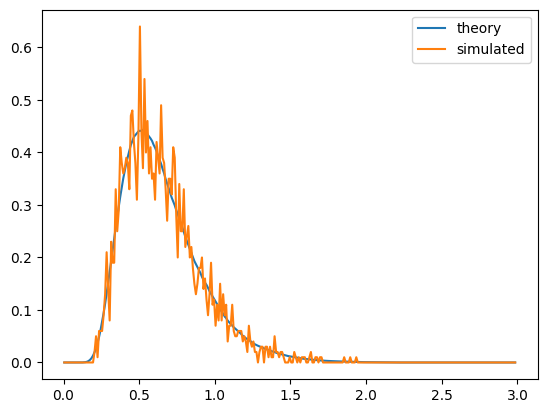

In [106]:
plt.plot(t_pts, non_censored_nan_removed_mean, label='theory')
plt.plot(t_pts, abort_rt_data_hist, label='simulated')
plt.legend();

In [99]:
np.trapz(non_censored_nan_removed_mean, t_pts)

0.2451408442382877

In [100]:
from scipy.integrate import quad
quad(PDF_hit_V_A_change, 0 , np.inf, args=(V_A_old, V_A_new, theta_A, 0.5))

(0.9999999998108473, 1.4769700573680211e-08)